<hr style="margin-bottom: 50px;">
<center>
    <h1 style="margin-top: 0; margin-bottom: 0;">
        <b><u>Random Forest</u></b>
    </h1>
</center>
<hr style="margin-top: 50px;">


In [1]:
import config, src

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [2]:
data = src.load_data(config.PROCESSED_DATA_COMBINED_RAP_HIPHOP_FILE)

X_train, X_test, y_train, y_test = src.split_data(data, target_column='music_genre')

class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train,
)
class_weight = dict(zip(np.unique(y_train), class_weight))

Données chargées avec succès.


In [3]:
rf_classifier = RandomForestClassifier(random_state=0, oob_score=True, n_jobs=-1, class_weight=class_weight)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={np.int64(0): np.float64(1.0701870734201),
                                     np.int64(1): np.float64(1.0715194776449757),
                                     np.int64(2): np.float64(1.0766130153170432),
                                     np.int64(3): np.float64(1.077421688087687),
                                     np.int64(4): np.float64(1.0980408834453232),
                                     np.int64(5): np.float64(1.0641004505989669),
                                     np.int64(6): np.float64(1.0741942641593165),
                                     np.int64(7): np.float64(0.6427516388681437),
                                     np.int64(8): np.float64(1.06594555913357)},
                       n_jobs=-1, oob_score=True, random_state=0)

----------------------------------------------------------------------------------------------------

Global accuracy : 0.6647733140555613
Global log loss : 1.0984912750341949
Global precision : 0.653294584013108
Global recall : 0.649350531804443
Global F1 score : 0.6499481721338882
Global ROC-AUC score : 0.9316459801148037

              Precision    Recall  F1 score
Alternative   0.436536  0.375894  0.403952
Anime         0.794926  0.764228  0.779275
Blues         0.605901  0.573280  0.589139
Classical     0.861139  0.856859  0.858994
Country       0.626122  0.580944  0.602687
Electronic    0.688963  0.646444  0.667026
Jazz          0.587462  0.584507  0.585981
Rap/Hip-Hop   0.792341  0.855562  0.822739
Rock          0.486261  0.606438  0.539741

----------------------------------------------------------------------------------------------------


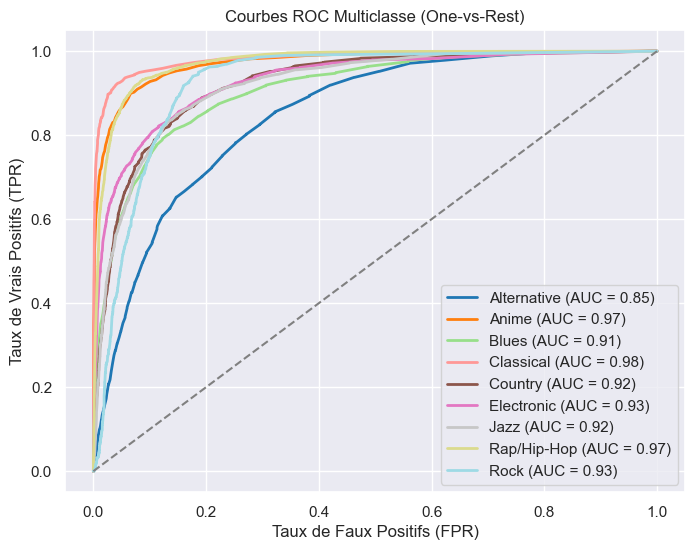

----------------------------------------------------------------------------------------------------


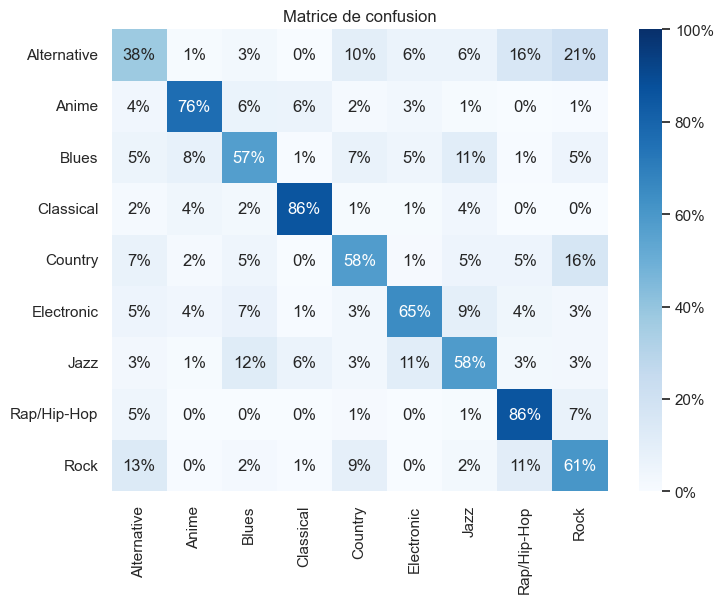

----------------------------------------------------------------------------------------------------


In [4]:
src.evaluate_model(rf_classifier, X_test, y_test, classes=config.CLASSES_COMBINED_RAP_HIPHOP)

In [5]:
params = {
    'max_depth' : [10, 20, 30, 50],
    'min_samples_split': [5, 10, 30, 50],
    'min_samples_leaf': [10, 20, 30, 50],
    'max_features' : [2, 5, 10],
}

In [6]:
cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

rs_rf_classifier = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=0, class_weight=class_weight),
    param_distributions=params,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_strat,
    verbose=1,
    random_state=0,
)
rs_rf_classifier.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(class_weight={np.int64(0): np.float64(1.0701870734201),
                                                                  np.int64(1): np.float64(1.0715194776449757),
                                                                  np.int64(2): np.float64(1.0766130153170432),
                                                                  np.int64(3): np.float64(1.077421688087687),
                                                                  np.int64(4): np.float64(1.0980408834453232),
                                                                  np.int64(5): np...9),
                                                                  np.int64(6): np.float64(1.0741942641593165),
                                                                  np.int64(7): np.float64(0.6427516388681437),
                                                                  np.int64(8): np.float64(1.06594555913357)},
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 50],
                                        'max_features': [2, 5, 10],
                                        'min_samples_leaf': [10, 20, 30, 50],
                                        'min_samples_split': [5, 10, 30, 50]},
                   random_state=0, scoring='accuracy', verbose=1)

In [7]:
src.save_model(rs_rf_classifier, 'rs_rf_classifier')

Modèle et ses métadonnées sauvegardées dans : /Users/lucascaio/Desktop/Fac/Master/M2/Bloc de base/Apprentissage statistique/music-genre-prediction/models


Meilleure valeur de min_samples_split : 30
Meilleure valeur de min_samples_leaf : 10
Meilleure valeur de max_features : 2
Meilleure valeur de max_depth : 20


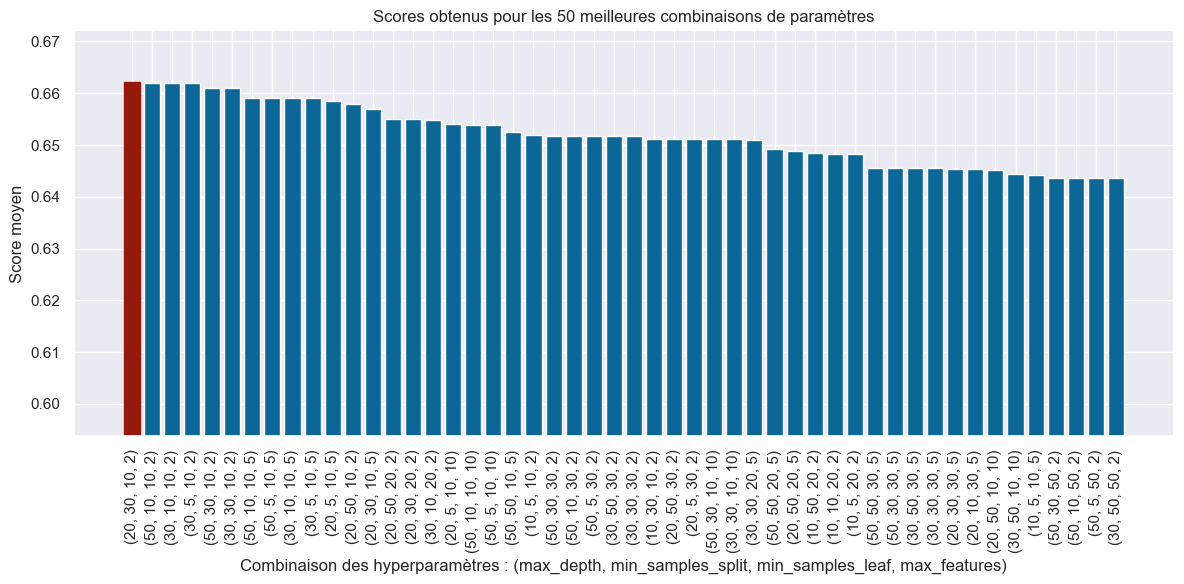

In [8]:
best_params = src.plot_gridsearch(rs_rf_classifier, params)

In [9]:
rf_classifier = RandomForestClassifier(
    random_state=0,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    oob_score=True,
    n_jobs=-1,
    class_weight=class_weight,
    )
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={np.int64(0): np.float64(1.0701870734201),
                                     np.int64(1): np.float64(1.0715194776449757),
                                     np.int64(2): np.float64(1.0766130153170432),
                                     np.int64(3): np.float64(1.077421688087687),
                                     np.int64(4): np.float64(1.0980408834453232),
                                     np.int64(5): np.float64(1.0641004505989669),
                                     np.int64(6): np.float64(1.0741942641593165),
                                     np.int64(7): np.float64(0.6427516388681437),
                                     np.int64(8): np.float64(1.06594555913357)},
                       max_depth=20, max_features=2, min_samples_leaf=10,
                       min_samples_split=30, n_jobs=-1, oob_score=True,
                       random_state=0)

----------------------------------------------------------------------------------------------------

Global accuracy : 0.6700402767737271
Global log loss : 1.0348892315587768
Global precision : 0.6580664247008366
Global recall : 0.6561477457855972
Global F1 score : 0.6529598305849318
Global ROC-AUC score : 0.937854122704349

              Precision    Recall  F1 score
Alternative   0.496361  0.348315  0.409364
Anime         0.770299  0.732724  0.751042
Blues         0.616468  0.567298  0.590862
Classical     0.835249  0.866799  0.850732
Country       0.638151  0.600370  0.618684
Electronic    0.662741  0.647490  0.655026
Jazz          0.583075  0.568410  0.575650
Rap/Hip-Hop   0.820963  0.843914  0.832280
Rock          0.499290  0.730010  0.592999

----------------------------------------------------------------------------------------------------


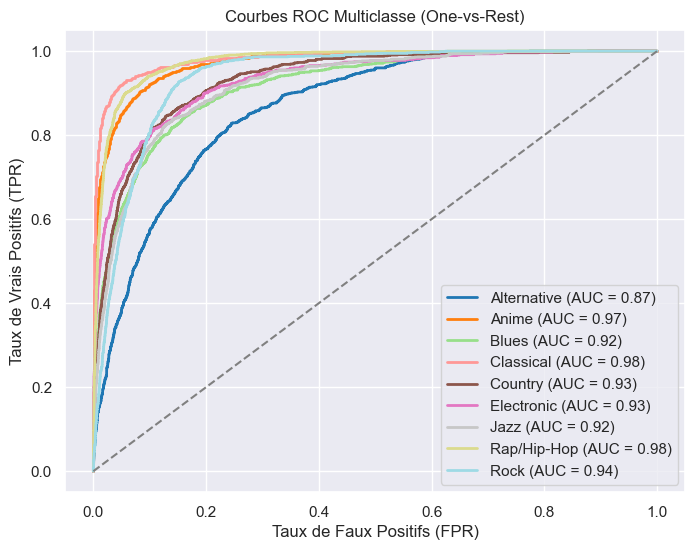

----------------------------------------------------------------------------------------------------


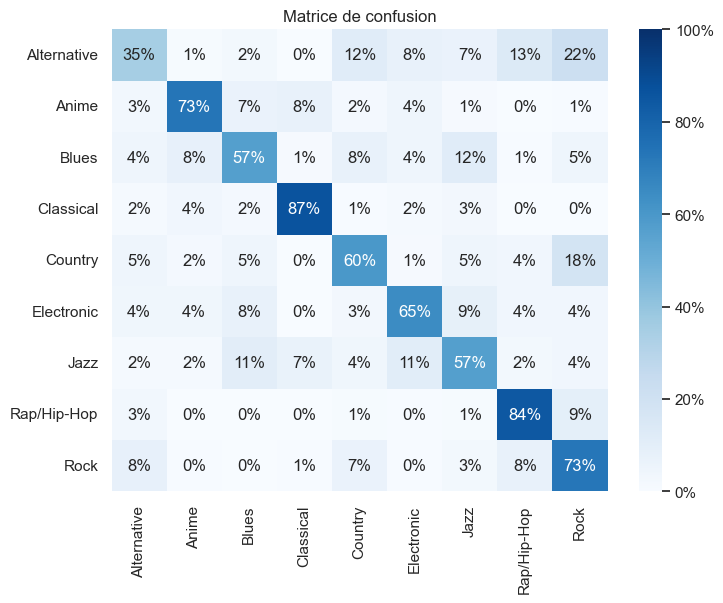

----------------------------------------------------------------------------------------------------


In [11]:
src.evaluate_model(rf_classifier, X_test, y_test, classes=config.CLASSES_COMBINED_RAP_HIPHOP)

In [12]:
src.save_model(rf_classifier, 'rf_classifier')

Modèle et ses métadonnées sauvegardées dans : /Users/lucascaio/Desktop/Fac/Master/M2/Bloc de base/Apprentissage statistique/music-genre-prediction/models


---